In [ ]:
! kaggle competitions download -c digit-recognizer

In [ ]:
! pip install pandas matplotlib torchvision

In [142]:
import torch

In [143]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device:", device)

using device: cuda


In [144]:
from torch.utils.data import Dataset
import pandas as pd

class DigitDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        df = pd.read_csv(path)
        self.y = torch.tensor(df.loc[:, "label"])

        X = df.loc[:, df.columns != "label"]
        X["combined"] = X.apply(lambda x: x.tolist(), axis=1)
        self.X = torch.tensor(X["combined"]).view((-1, 28, 28)).float() / 255
        self.X = self.X.unsqueeze(1)
        
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [145]:
from torch.utils.data import random_split

dataset = DigitDataset("train.csv")
valid_size = 2000
train_size = len(dataset) - valid_size

train_ds, valid_ds = random_split(dataset, [train_size, valid_size])
len(train_ds), len(valid_ds)

(40000, 2000)

In [146]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

In [154]:
import torch.nn as nn
from torchvision.transforms.v2 import RandomRotation

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3), # (B, 1, 28, 28) -> (B, 6, 26, 26)
            nn.ReLU(),
            nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5), # (B, 6, 26, 26) -> (B, 12, 22, 22)
            nn.ReLU(),
            nn.Conv2d(in_channels=12, out_channels=24, kernel_size=7), # (B, 12, 22, 22) -> (B, 24, 16, 16)
            nn.ReLU(),
            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=7), # (B, 24, 16, 16) -> (B, 48, 10, 10)
            nn.ReLU(),
            nn.Conv2d(in_channels=48, out_channels=96, kernel_size=10), # (B, 48, 10, 10) -> (B, 96, 1, 1)
            nn.ReLU(),
            nn.Flatten(), # (B, 96, 1, 1) -> (B, 96),
            nn.Linear(in_features=96, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=10) # (B, 96) -> (B, 10)
        )
        self.rotate = RandomRotation(10)

    def forward(self, x):
        if self.training:
            x = self.rotate(x)
        return self.layers(x)

In [148]:
def test(dataloader, model, loss_fn):
    loss_b = []
    correct = 0
    size = len(dataloader.dataset)

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            loss_b.append(loss.item())
            correct += (pred.argmax(1) == y).view(-1).int().sum().item()
    
    return (torch.tensor(loss_b).mean().item(), correct / size)

In [149]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

In [161]:
model = Model().to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(num_params)

538760


In [162]:
for epoch in range(17):
    epoch += 1
    # lr = max(1e-6, 10**(-epoch))
    lr = 10**(-1.2)
    train(train_dl, model, nn.CrossEntropyLoss(), torch.optim.SGD(model.parameters(), lr=lr))
    print("epoch: ", epoch)
    print("train: ", test(train_dl, model, nn.CrossEntropyLoss()))
    print("test: ", test(valid_dl, model, nn.CrossEntropyLoss()))

epoch:  1
train:  (0.15324538946151733, 0.952825)
test:  (0.1485752910375595, 0.957)
epoch:  2
train:  (0.0717848390340805, 0.97765)
test:  (0.08283387124538422, 0.9745)
epoch:  3
train:  (0.10396996140480042, 0.967975)
test:  (0.10656264424324036, 0.9665)
epoch:  4
train:  (0.04296287149190903, 0.98625)
test:  (0.05648387596011162, 0.984)
epoch:  5
train:  (0.030190905556082726, 0.990725)
test:  (0.046370524913072586, 0.986)
epoch:  6
train:  (0.02525605633854866, 0.991425)
test:  (0.0542823001742363, 0.9875)
epoch:  7
train:  (0.0198944341391325, 0.99375)
test:  (0.03762726113200188, 0.989)
epoch:  8
train:  (0.017786337062716484, 0.993875)
test:  (0.041523441672325134, 0.988)
epoch:  9
train:  (0.013524062000215054, 0.99595)
test:  (0.05939139798283577, 0.986)
epoch:  10
train:  (0.011063151992857456, 0.996275)
test:  (0.04791059345006943, 0.9865)
epoch:  11
train:  (0.009521272964775562, 0.99725)
test:  (0.073545902967453, 0.985)
epoch:  12
train:  (0.013989133760333061, 0.995625)


In [74]:
lrei = []
lossi = []
loss_fn = nn.CrossEntropyLoss()
for lre in torch.linspace(-2, -0.7, 500).tolist():
    optimizer = torch.optim.SGD(model.parameters(), lr=10**(lre))
    X, y = next(iter(train_dl))
    X, y = X.to(device), y.to(device)

    pred = model(X)
    loss = loss_fn(pred, y)
    lrei.append(lre)
    lossi.append(loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    


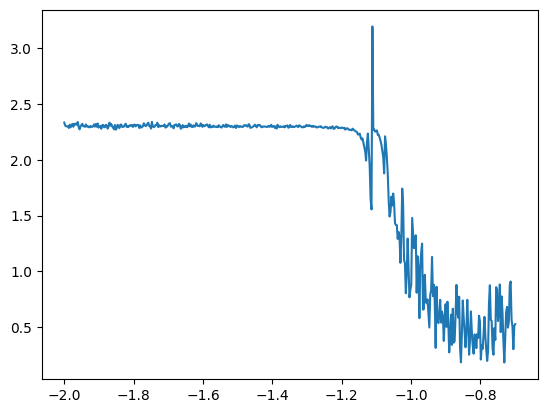

In [75]:
import matplotlib.pyplot as plt

plt.plot(lrei, lossi)
plt.show()

In [163]:
torch.save(model, "model.pth")

In [164]:
from torch.utils.data import Dataset
import pandas as pd

class DigitTestDataset(Dataset):
    def __init__(self, path):
        super().__init__()
        df = pd.read_csv(path)
        row_count = len(df)
        self.y = torch.ones((row_count,))

        X = df.loc[:, df.columns != "label"]
        X["combined"] = X.apply(lambda x: x.tolist(), axis=1)
        self.X = torch.tensor(X["combined"]).view((-1, 28, 28)).float() / 255
        self.X = self.X.unsqueeze(1)
        
    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [165]:
test_ds = DigitTestDataset("test.csv")

In [166]:
test_dl = DataLoader(test_ds, batch_size=64, shuffle=False)

In [167]:
def infer(dataloader, model):
    model.eval()
    with torch.no_grad():
        res = []
        for X, _ in dataloader:
            X = X.to(device)
            pred = model(X)
            res.append(pred.argmax(1))
        return torch.cat(res, dim=0)

In [168]:
indexes = torch.linspace(1, 28000, 28000).int()
results = infer(test_dl, model)
data = {
    "ImageId": indexes.cpu(),
    "Label": results.cpu()
}
submission = pd.DataFrame(data)

In [169]:
submission.to_csv("submission.csv", index=False)